In [16]:
# import necessary libraries
import itertools
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.gensim_models 
from gensim import corpora
from gensim.models import CoherenceModel,LdaModel
from sklearn.metrics import silhouette_samples, silhouette_score

# ignore warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
def force_format(texts):
    return [str(t) for t in texts]

In [6]:
dataset = pd.read_json("News_Category_Dataset_v2.json", lines=True, dtype={"headline": str})

In [7]:
texts = force_format(dataset["headline"])

In [8]:
def compute_word_occurences(texts):
    words = itertools.chain.from_iterable(texts)
    word_count = pd.Series(words).value_counts()
    word_count = pd.DataFrame({"Word": word_count.index, "Count": word_count.values})
    return word_count

In [9]:
def get_l_texts(text_file): #text_file is a .txt file from preprocessing to avoid doing it again
    l_texts=[]
    with open(text_file, "r") as f:
        line = f.readlines()
        list_line = [l.strip() for l in line]
        for l in list_line:
            l_texts.append(ast.literal_eval(l))
    return l_texts

In [10]:
l_texts = get_l_texts("l_texts.txt")
print(l_texts[:10])

[['mass_shooting', 'texas', 'week', 'tv'], ['smith', 'join', 'diplo', 'nicky', 'jam', 'world_cup', 'official', 'song'], ['hugh', 'grant', 'marries', 'time', 'age'], ['jim_carrey', 'blasts', 'castrato', 'adam', 'schiff', 'democrats', 'artwork'], ['julianna', 'margulie', 'donald', 'poop', 'bag', 'pick', 'dog'], ['morgan_freeman', 'devastate', 'sexual_harassment', 'claim', 'undermine', 'legacy'], ['donald', 'lovin', 'mcdonald', 'jingle', 'tonight', 'bit'], ['watch', 'amazon', 'prime', 'week'], ['mike', 'myers', 'reveal', 'fourth', 'austin', 'power', 'film'], ['watch', 'hulu', 'week']]


# LDA

In [11]:
# Create a dictionary
dictionary = corpora.Dictionary(l_texts)

# Create a corpus
corpus = [dictionary.doc2bow(text) for text in l_texts]

In [12]:
result={"num_topics":[], "coherence_score_cv":[],"coherence_score_npmi":[]}

for n in range(50, 65):
    lda_model = LdaModel(corpus, num_topics=n, id2word=dictionary)
    coherence_model_cv= CoherenceModel(model=lda_model, texts=l_texts, dictionary=dictionary, coherence='c_v')
    coherence_score_cv = coherence_model_cv.get_coherence()
    coherence_model_npmi= CoherenceModel(model=lda_model, texts=l_texts, dictionary=dictionary, coherence='c_npmi')
    coherence_score_npmi = coherence_model_npmi.get_coherence()
    print("Number of topics: ", n, " Coherence Score: ", coherence_score_npmi,coherence_score_cv)
    result["num_topics"].append(n)
    result["coherence_score_cv"].append(coherence_score_cv)
    result["coherence_score_npmi"].append(coherence_score_npmi)

Number of topics:  50  Coherence Score:  -0.27895125469968546 0.504553057860556
Number of topics:  51  Coherence Score:  -0.2842450560471312 0.5126327086607517
Number of topics:  52  Coherence Score:  -0.2849444640783974 0.5123811426208651
Number of topics:  53  Coherence Score:  -0.29555774937786844 0.5278318459260313
Number of topics:  54  Coherence Score:  -0.2949168485970032 0.5248025650124957
Number of topics:  55  Coherence Score:  -0.2948419864108301 0.5264235038619777
Number of topics:  56  Coherence Score:  -0.29549266656996587 0.5255858133703878
Number of topics:  57  Coherence Score:  -0.29733281244122794 0.5273908048528966
Number of topics:  58  Coherence Score:  -0.30205938172859365 0.5366450199861357
Number of topics:  59  Coherence Score:  -0.29720611491779414 0.5271187795574954


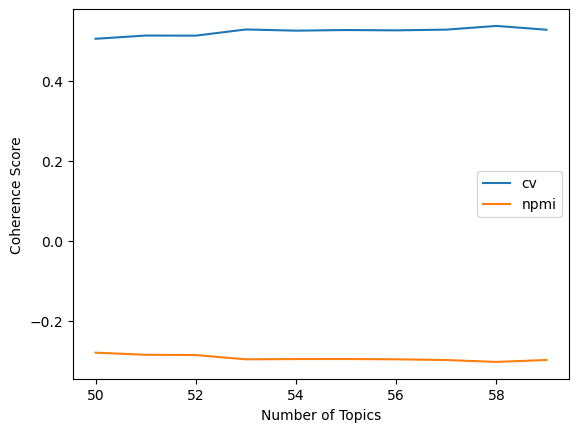

In [18]:
# Plot the coherence scores for elbow method

plt.plot(result["num_topics"], result["coherence_score_cv"])
plt.plot(result["num_topics"], result["coherence_score_npmi"])
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.legend(("cv", "npmi"), loc='best')
plt.show()

In [20]:
optimal_n = result["num_topics"][np.argmax(result["coherence_score_cv"])]
optimal_lda_model = LdaModel(corpus, num_topics=optimal_n, id2word=dictionary)

In [ ]:
#Get the number of words per topic
def get_numbers_of_words_per_topic(lda_model):
    topics = lda_model.show_topics(num_topics=optimal_n)
    topics_words = [(tp[0], len([wd[0] for wd in tp[1]])) for tp in topics]
    return topics_words

print("Optimal number of topics: ", optimal_n)
print("Number of words per topic: ",get_numbers_of_words_per_topic(optimal_lda_model))
print("Maximun number of words per topic: ", max([t[1] for t in get_numbers_of_words_per_topic(optimal_lda_model)]))
print("Minimum number of words per topic: ", min([t[1] for t in get_numbers_of_words_per_topic(optimal_lda_model)]))

Optimal number of topics:  55
Number of words per topic:  [(0, 162), (1, 161), (2, 159), (3, 162), (4, 167), (5, 151), (6, 155), (7, 158), (8, 156), (9, 162), (10, 157), (11, 165), (12, 154), (13, 160), (14, 158), (15, 150), (16, 162), (17, 164), (18, 159), (19, 176), (20, 159), (21, 156), (22, 159), (23, 159), (24, 150), (25, 171), (26, 163), (27, 154), (28, 182), (29, 153), (30, 160), (31, 161), (32, 167), (33, 170), (34, 164), (35, 162), (36, 166), (37, 171), (38, 158), (39, 158), (40, 166), (41, 159), (42, 150), (43, 149), (44, 157), (45, 172), (46, 162), (47, 157), (48, 163), (49, 163), (50, 158), (51, 157), (52, 162), (53, 159), (54, 165)]
Maximun number of words per topic:  182
Minimum number of words per topic:  149


In [ ]:
#Get the coherence score for the optimal model
coherence_model= CoherenceModel(model=optimal_lda_model, texts=l_texts, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()
print("Coherence Score: ", coherence_score)

Coherence Score:  0.5213913622558476


In [ ]:
#Creating Topic Distance Visualization 
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)

c:\Users\David-Desktop\miniconda3\envs\NLP\lib\site-packages\pandas\core\dtypes\cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
48     0.272106 -0.397288       1        1  3.219104
47     0.145753  0.132184       2        1  2.607532
42     0.083867  0.042551       3        1  2.473336
20     0.112096  0.071062       4        1  2.436851
53     0.106458  0.064356       5        1  2.246640
49     0.058315  0.024839       6        1  2.058745
14     0.156223  0.162934       7        1  2.051744
26     0.067753  0.030582       8        1  2.051117
41     0.050196  0.020185       9        1  2.039902
4      0.065304  0.029016      10        1  2.014690
35     0.060632  0.026200      11        1  1.979561
7      0.040211  0.015196      12        1  1.957769
13     0.013916  0.004350      13        1  1.891683
0      0.073469  0.034516      14        1  1.888950
40     0.083604  0.042191      15        1  1.856201
16     0.022871  0.007612      16        1  1.838966
17     0.055289  0.022879      17        1  1.835628
36     0.001896  0.000165      18        1  1.820013
30    -0.004572 -0.001830      19        1  1.801360
33     0.032075  0.011518      20        1  1.798057
12    -0.005721 -0.002183      21        1  1.791400
44     0.071412  0.033041      22        1  1.788760
6     -0.038607 -0.010630      23        1  1.788743
54     0.046154  0.018129      24        1  1.750014
31    -0.009646 -0.003288      25        1  1.747867
37     0.005383  0.001388      26        1  1.736973
45    -0.031832 -0.009054      27        1  1.734738
32     0.010936  0.003215      28        1  1.681679
51    -0.006570 -0.002396      29        1  1.614309
8     -0.028473 -0.008258      30        1  1.591415
56    -0.044237 -0.011798      31        1  1.574751
15    -0.031094 -0.008911      32        1  1.570157
39    -0.038522 -0.010598      33        1  1.557974
10    -0.051943 -0.013367      34        1  1.555552
29    -0.021830 -0.006620      35        1  1.549921
9     -0.028588 -0.008336      36        1  1.514118
23    -0.004521 -0.001751      37        1  1.513575
24    -0.079764 -0.018118      38        1  1.502113
38    -0.037612 -0.010379      39        1  1.493157
52    -0.024170 -0.007237      40        1  1.485659
34     0.014747  0.004540      41        1  1.484615
18    -0.028461 -0.008215      42        1  1.484495
43    -0.050336 -0.013043      43        1  1.437108
1     -0.082215 -0.018443      44        1  1.429559
25    -0.056816 -0.014281      45        1  1.400403
11    -0.052251 -0.013359      46        1  1.390689
50    -0.045496 -0.012125      47        1  1.372523
2     -0.059479 -0.014734      48        1  1.363639
5     -0.105311 -0.021398      49        1  1.358640
55    -0.084732 -0.018799      50        1  1.344588
22    -0.018223 -0.005744      51        1  1.330547
3     -0.104137 -0.021266      52        1  1.314630
27    -0.053842 -0.013761      53        1  1.309264
46    -0.048644 -0.012714      54        1  1.290792
21    -0.027386 -0.008010      55        1  1.283031
19    -0.080939 -0.018255      56        1  1.279163
28    -0.053468 -0.013629      57        1  1.259421
57    -0.111875 -0.022112      58        1  1.236775
58    -0.099352 -0.020720      59        1  1.219393, topic_info=          Term          Freq         Total Category  logprob  loglift
204      photo  26704.000000  26704.000000  Default  30.0000  30.0000
305      video  14353.000000  14353.000000  Default  29.0000  29.0000
496        day   7676.000000   7676.000000  Default  28.0000  28.0000
490       year   7175.000000   7175.000000  Default  27.0000  27.0000
294       make   7787.000000   7787.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
446      probe    162.994785    164.884234  Topic59  -4.3717   4.3953
1133  reporter    127.119093    129.008576  Topic59  -4.6203   4.3921
126    montana    105.782728    107.672166  Topic59  -4.8041   4.3891
1802       mtv     87.92